In [8]:
!pip install shap


In [9]:
import joblib
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load sample data
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model and assign it to best_model
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [10]:

joblib.dump(best_model, "iris_xgb_pipeline.pkl")
print("Model saved successfully.")



Model saved successfully.


In [11]:
import os
print(os.getcwd())
print(os.listdir())


C:\Users\joyasree paul\Downloads\joyasreepython
['.ipynb_checkpoints', 'IMDB movies rating prediction.ipynb', 'IRIS FLOWER CLASSIFICATION .ipynb', 'iris_xgb_pipeline.pkl', 'output_features.xlsx', 'output_target.xlsx', 'TITANIC PREDICTION.ipynb', 'titanic_predictions_with_columns.csv']


Cross-validation scores: [0.96666667 0.96666667 0.93333333 0.96666667 1.        ]
Mean CV Accuracy: 0.9667

Test Accuracy: 1.0

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00        10

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



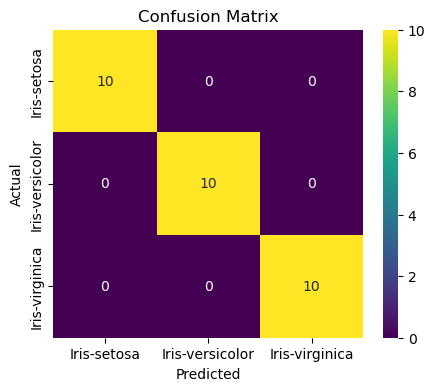

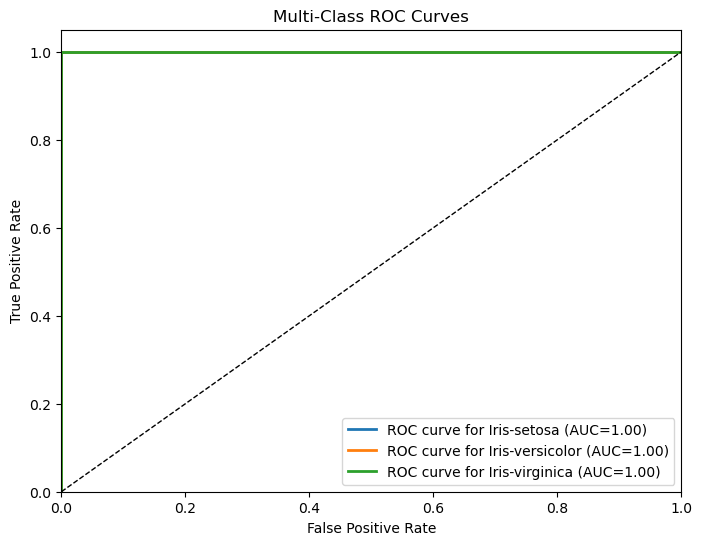

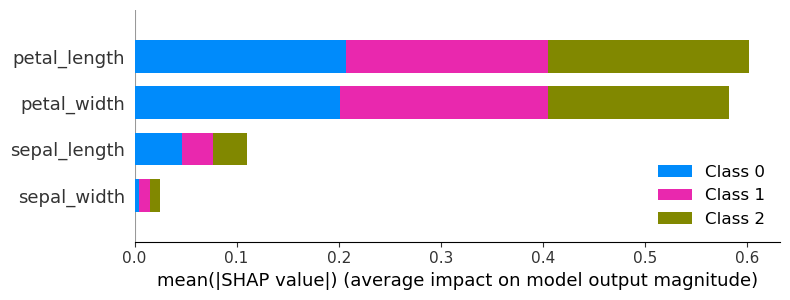


Sample Features:
    sepal_length  sepal_width  petal_length  petal_width
0           6.0          3.0           5.0          1.5
Predicted Species: Iris-versicolor
Prediction Probabilities: {'Iris-setosa': np.float64(0.0), 'Iris-versicolor': np.float64(0.5), 'Iris-virginica': np.float64(0.5)}


In [12]:
# --- 1. Imports ---
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# --- 2. Load Your Best Model ---
model_path = "iris_xgb_pipeline.pkl"  # Path to your saved pipeline/model
best_model = joblib.load(model_path)

# --- 3. Load Data ---
data = pd.read_csv(r"C:\\Users\\joyasree paul\\Downloads\\IRIS (1).csv")

X = data.drop('species', axis=1)
y = data['species']

# Encoding target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- 4. Cross-validation (Use NumPy arrays to avoid warning) ---
cv_scores = cross_val_score(best_model, X.values, y_encoded, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# --- 6. Predictions and Evaluation (use .values to avoid feature name warning) ---
y_pred = best_model.predict(X_test.values)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- 7. Multi-Class ROC Curves ---
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = best_model.predict_proba(X_test.values)

plt.figure(figsize=(8,6))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, lw=2,
             label=f"ROC curve for {le.classes_[i]} (AUC={auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend()
plt.show()

# --- 8. SHAP Explainability ---
try:
    # If pipeline with named steps, extract XGB model and transform test data accordingly
    if hasattr(best_model, 'named_steps'):
        # Adjust these step names based on your pipeline
        xgb_model = best_model.named_steps.get('xgb', None)
        scaler = best_model.named_steps.get('scaler', None)
        if scaler is not None:
            processed_X_test = scaler.transform(X_test.values)
        else:
            processed_X_test = X_test.values
        explainer = shap.Explainer(xgb_model)
    else:
        xgb_model = best_model
        processed_X_test = X_test.values
        explainer = shap.Explainer(xgb_model)
    
    shap_values = explainer(processed_X_test)
    shap.summary_plot(shap_values, X_test, feature_names=X.columns)
except Exception as e:
    print(f"SHAP plot exception: {e}")

# --- 9. Sample Prediction Demo ---
sample = pd.DataFrame([[6.0, 3.0, 5.0, 1.5]], columns=X.columns)
pred_idx = best_model.predict(sample.values)[0]
pred_species = le.classes_[pred_idx]
pred_probs = best_model.predict_proba(sample.values)[0]

print("\nSample Features:\n", sample)
print("Predicted Species:", pred_species)
print("Prediction Probabilities:", dict(zip(le.classes_, pred_probs)))
